In [10]:
import numpy as np
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
from utils import *
from model import *
import os
import sys
import cv2


import torch
import torchvision
from torchvision import ops
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

In [11]:
class ObjectDetectionDataset(Dataset):
    '''
    A Pytorch Dataset class to load the images and their corresponding annotations.
    
    Returns
    ------------
    images: torch.Tensor of size (B, C, H, W)
    gt bboxes: torch.Tensor of size (B, max_objects, 4)
    gt classes: torch.Tensor of size (B, max_objects)
    '''
    def __init__(self, annotation_path, img_dir, img_size, name2idx):
        self.annotation_path = annotation_path
        self.img_dir = img_dir
        self.img_size = img_size
        self.name2idx = name2idx
        
        self.img_data_all, self.gt_bboxes_all, self.gt_classes_all = self.get_data()
        
    def __len__(self):
        return self.img_data_all.size(dim=0)
    
    def __getitem__(self, idx):
        return self.img_data_all[idx], self.gt_bboxes_all[idx], self.gt_classes_all[idx]
        
    def get_data(self):
        img_data_all = []
        gt_idxs_all = []
        
        gt_boxes_all, gt_classes_all, img_paths = parse_annotation(self.annotation_path, self.img_dir, self.img_size)
        
        
        print('after annotations')
        # print(gt_boxes_all)
        print(gt_classes_all)
        # print(img_paths)


        for i, img_path in enumerate(img_paths):
            
            # skip if the image path is not valid
            if (not img_path) or (not os.path.exists(img_path)):
                continue
                
            # read and resize image
            img = io.imread(img_path)
            img = resize(img, self.img_size)
            
            # convert image to torch tensor and reshape it so channels come first
            img_tensor = torch.from_numpy(img).permute(2, 0, 1)
            
            # encode class names as integers
            gt_classes = gt_classes_all[i]
            gt_idx = torch.Tensor([self.name2idx[name] for name in gt_classes])
            
            img_data_all.append(img_tensor)
            gt_idxs_all.append(gt_idx)
        
        # pad bounding boxes and classes so they are of the same size
        gt_bboxes_pad = pad_sequence(gt_boxes_all, batch_first=True, padding_value=-1)
        gt_classes_pad = pad_sequence(gt_idxs_all, batch_first=True, padding_value=-1)
        
        # stack all images
        img_data_stacked = torch.stack(img_data_all, dim=0)
        
        return img_data_stacked.to(dtype=torch.float32), gt_bboxes_pad, gt_classes_pad


In [12]:
def training_loop(model, learning_rate, train_dataloader, n_epochs):
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    loss_list = []
    
    for i in tqdm(range(n_epochs)):
        total_loss = 0
        j = 0
        for img_batch, gt_bboxes_batch, gt_classes_batch in train_dataloader:
            
            # forward pass
            # print(img_batch.shape)
            # print(gt_bboxes_batch)
            # print(gt_classes_batch)
            print('just before model forward')
            loss = model(img_batch, gt_bboxes_batch, gt_classes_batch)
            
            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            j += 1
            break
        print(j)
        
        loss_list.append(total_loss)
        
    return loss_list

In [13]:
img_width = 640
img_height = 480

img_size = (480, 640)
out_size = (15, 20)
n_classes = 2 # exclude pad idx
roi_size = (2, 2)


annotation_path = "data/annotations.xml"
image_dir = os.path.join("data", "images")
# annotation_path = 'Data_annotation_changedName_short/annots'
# image_dir = 'Data_annotation_changedName_short/images'
annotation_path = 'Data_annotation_postbar_short/annots'
image_dir = 'Data_annotation_postbar_short/images'


name2idx = {'pad': -1, 'bar': 0, 'post': 1}

idx2name = {v:k for k, v in name2idx.items()}


od_dataset = ObjectDetectionDataset(annotation_path, image_dir, (img_height, img_width), name2idx)
od_dataloader = DataLoader(od_dataset, batch_size=2)


after annotations
[['post', 'post', 'bar', 'bar', 'bar'], ['bar', 'post', 'post']]


In [14]:
img_size = (480, 640)
out_size = (15, 20)
n_classes = 2 # exclude pad idx
roi_size = (2, 2)



# Model class must be defined somewhere
model2 = TwoStageDetector(img_size, out_size, 2048, n_classes, roi_size)
model2.load_state_dict(torch.load('model_postbar_530.pt'))
# model2.eval()

ProposalModule:
(2048, 512)
Dropout(p=0.3, inplace=False)
Conv2d(512, 9, kernel_size=(1, 1), stride=(1, 1))
Conv2d(512, 36, kernel_size=(1, 1), stride=(1, 1))


<All keys matched successfully>

In [15]:

# Training
# learning_rate = 1e-3
# n_epochs = 1

# model2.train()

# loss_list = training_loop(model2, learning_rate, od_dataloader, n_epochs)


In [16]:

img_width = 640
img_height = 480
annotation_path = 'veo_test'
# image_dir = 'veo_test'
image_dir = 'Data_annotation_postbar_short/veo_test'

# name2idx = {'pad': -1, 'camel': 0, 'bird': 1}
# name2idx = {'pad': -1, 'goal': 0}
name2idx = {'pad': -1, 'bar': 0, 'post': 1}

idx2name = {v:k for k, v in name2idx.items()}


print(os.listdir(image_dir))

img_data_all = []
img_size = (480, 640)


img_batch = None
for i, img_path in enumerate(os.listdir(image_dir)):
    # skip if the image path is not valid
    path = image_dir + '/' + img_path
    if (not img_path) or (not os.path.exists(path)):
        continue
        
    # read and resize image
    # img = io.imread(path)
    img = cv2.imread(path)
    b,g,r = cv2.split(img)       # get b,g,r
    img = cv2.merge([r,g,b])
    if 'right' in path:
        img = img[200:700,2000:2900]
    
    if 'left' in path:
        img = img[200:800,750:1800]

    print(img.shape)
    img = resize(img, img_size)

    
    # convert image to torch tensor and reshape it so channels come first
    img_tensor = torch.from_numpy(img).permute(2, 0, 1)            
    img_data_all.append(img_tensor)
        

    # stack all images
    img_data_stacked = torch.stack(img_data_all, dim=0)
    
    img_batch = img_data_stacked.to(dtype=torch.float32)

print(img_batch.shape)



(2, 3, 480, 640)


['83.jpg', 'new_test.PNG', 'video_13_00_46_13_left001.png']
(745, 1598, 3)
(693, 1315, 3)
(600, 1050, 3)
torch.Size([3, 3, 480, 640])


(2, 3, 480, 640)

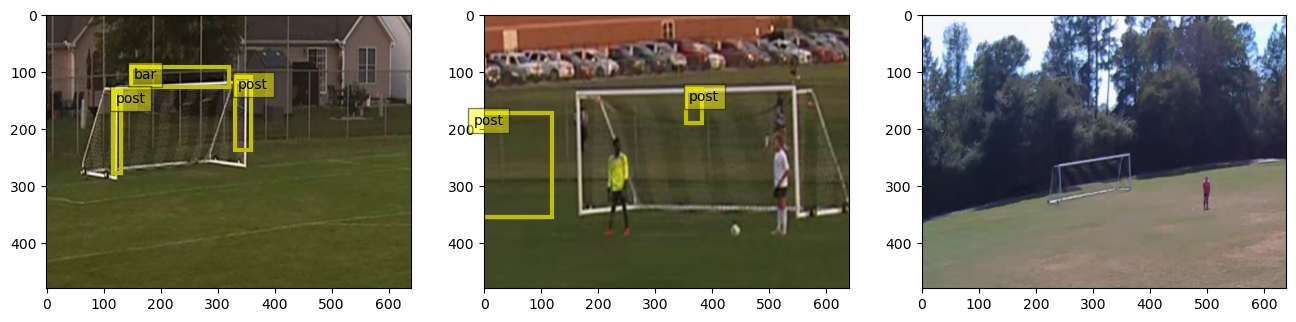

In [17]:

# Evaluation
model2.eval()
proposals_final, conf_scores_final, classes_final = model2.inference(img_batch, conf_thresh=0.97, nms_thresh=0.05)



height_scale_factor, width_scale_factor = 32, 32

# project proposals to the image space
prop_proj_1 = project_bboxes(proposals_final[0], width_scale_factor, height_scale_factor, mode='a2p')
prop_proj_2 = project_bboxes(proposals_final[1], width_scale_factor, height_scale_factor, mode='a2p')

# get classes
classes_pred_1 = [idx2name[cls] for cls in classes_final[0].tolist()]
classes_pred_2 = [idx2name[cls] for cls in classes_final[1].tolist()]


nrows, ncols = (1, 3)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_batch, fig, axes)
fig, _ = display_bbox(prop_proj_1, fig, axes[0], classes=classes_pred_1)
fig, _ = display_bbox(prop_proj_2, fig, axes[1], classes=classes_pred_2)

## First image is from the training set, the other two are images not from training set